In [1]:
import pandas as pd
# import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
FIGURES = Path("../") / 'results/figures'
FIGURES.mkdir(exist_ok=True)
TABLES = Path("../") / 'results/tables'
TABLES.mkdir(exist_ok=True)

In [3]:
named_colors = {
    "black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())

In [4]:
sns.set_style("whitegrid")
sns.set_palette(cud_palette)

In [6]:
df = pd.read_csv("../lrge_per_read_estimates.csv.zst", low_memory=False)
df

,accession,method,estimate
0,SRR26337672,ava,8.770038e+06
1,SRR26337672,ava,5.827195e+06
2,SRR26337672,ava,6.948782e+06
3,SRR26337672,ava,5.940084e+06
4,SRR26337672,ava,5.244973e+06
...,...,...,...
98090989,DRR287515,2set,2.791100e+06
98090990,DRR287515,2set,2.929138e+06
98090991,DRR287515,2set,8.320333e+05
98090992,DRR287515,2set,3.018133e+06


In [7]:
samples = pd.read_csv("../results/estimates/estimates.tsv", sep="\t")
true_sizes = dict()
for _, row in samples.iterrows():
    true_sizes[row["run"]] = row["true_size"]

In [8]:
# remove rows from df where the run is not in the true_sizes dict
df = df[df["accession"].isin(true_sizes.keys())]

In [9]:
df

,accession,method,estimate
0,SRR26337672,ava,8.770038e+06
1,SRR26337672,ava,5.827195e+06
2,SRR26337672,ava,6.948782e+06
3,SRR26337672,ava,5.940084e+06
4,SRR26337672,ava,5.244973e+06
...,...,...,...
98090989,DRR287515,2set,2.791100e+06
98090990,DRR287515,2set,2.929138e+06
98090991,DRR287515,2set,8.320333e+05
98090992,DRR287515,2set,3.018133e+06


In [10]:
df['relative_size'] = df['estimate'] / df['accession'].map(true_sizes)

/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_67596/1221095775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['relative_size'] = df['estimate'] / df['accession'].map(true_sizes)


In [11]:
groups = df.groupby(["accession", "method"])

In [12]:
# function to apply to each group. it takes the median of the relative size and the median of the finite relative sizes
# it also calculates the percentiles of the relative sizes in 2.5% steps
def f(group):
    relsizes = group["relative_size"]
    median = relsizes.median()
    finite_ixs = np.isfinite(relsizes)
    finite = relsizes[finite_ixs]
    finite_median = finite.median()
    percentiles = np.percentile(relsizes, np.arange(10, 90, 1.0))
    finite_percentiles = np.percentile(finite, np.arange(10, 90, 1.0))
    return pd.Series([median, finite_median] + list(percentiles) + list(finite_percentiles))

In [13]:
medians_df = groups.apply(f)

/Users/michael/sw/miniforge3/envs/lrge/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/michael/sw/miniforge3/envs/lrge/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/michael/sw/miniforge3/envs/lrge/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/michael/sw/miniforge3/envs/lrge/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/michael/sw/miniforge3/envs/lrge/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/michael/sw/miniforge3/envs/lrge/lib/python3.12/s

In [14]:
medians_df.columns = ["median", "finite_median"] + [f"percentile_{i}" for i in np.arange(10, 90, 1.0)] + [f"finite_percentile_{i}" for i in np.arange(10, 90, 1.0)]
medians_df.to_csv("medians.csv")

In [15]:
medians_df = pd.read_csv("medians.csv", index_col=["accession", "method"])
medians_df

median  finite_median  percentile_10.0  percentile_11.0  \
accession  method                                                              
DRR072240  2set    2.054183       2.002263         1.229393         1.252098   
           ava     2.002564       2.002564         1.286194         1.307587   
DRR126367  2set    1.213236       1.210372         0.840811         0.856846   
           ava     1.225226       1.225226         0.921892         0.937148   
DRR126418  2set    1.300121       1.288371         0.778657         0.806174   
...                     ...            ...              ...              ...   
SRR9970116 ava     1.005208       1.005208         0.690887         0.723657   
SRR9970117 2set    1.017161       1.016156         0.743548         0.755750   
           ava     1.007714       1.007714         0.805541         0.816779   
SRR9988395 2set    1.165778       1.118431         0.710937         0.723145   
           ava     1.114309       1.114309         0.740728         0.753814   

                   percentile_12.0  percentile_13.0  percentile_14.0  \
accession  method                                                      
DRR072240  2set           1.271330         1.291735         1.308739   
           ava            1.327206         1.345910         1.365832   
DRR126367  2set           0.877551         0.892100         0.905107   
           ava            0.951522         0.964294         0.976378   
DRR126418  2set           0.827361         0.842484         0.857766   
...                            ...              ...              ...   
SRR9970116 ava            0.744926         0.763889         0.777870   
SRR9970117 2set           0.764187         0.772409         0.781091   
           ava            0.826024         0.833422         0.840947   
SRR9988395 2set           0.739644         0.756275         0.770452   
           ava            0.768842         0.781303         0.793429   

                   percentile_15.0  percentile_16.0  percentile_17.0  ...  \
accession  method                                                     ...   
DRR072240  2set           1.332773         1.354916         1.380756  ...   
           ava            1.382230         1.399607         1.417360  ...   
DRR126367  2set           0.926163         0.938344         0.949326  ...   
           ava            0.987822         0.998604         1.008365  ...   
DRR126418  2set           0.876551         0.892555         0.906880  ...   
...                            ...              ...              ...  ...   
SRR9970116 ava            0.789235         0.798761         0.807341  ...   
SRR9970117 2set           0.790202         0.798775         0.807339  ...   
           ava            0.848150         0.854255         0.859850  ...   
SRR9988395 2set           0.783420         0.793041         0.804291  ...   
           ava            0.803568         0.814928         0.824883  ...   

                   finite_percentile_80.0  finite_percentile_81.0  \
accession  method                                                   
DRR072240  2set                  3.464128                3.574191   
           ava                   3.396090                3.519595   
DRR126367  2set                  1.562928                1.577023   
           ava                   1.487213                1.503705   
DRR126418  2set                  1.823299                1.865737   
...                                   ...                     ...   
SRR9970116 ava                   1.243040                1.254369   
SRR9970117 2set                  1.272122                1.287122   
           ava                   1.212136                1.222904   
SRR9988395 2set                  1.625533                1.652327   
           ava                   1.521788                1.548832   

                   finite_percentile_82.0  finite_percentile_83.0  \
accession  method                                                   
DRR07

In [16]:
# melt data so that finite and all medians are in the same column with a column indicating which one it is
melted = medians_df.reset_index().melt(id_vars=["accession", "method"], value_vars=["median", "finite_median"], var_name="type", value_name="value")

<Axes: xlabel='method', ylabel='value'>

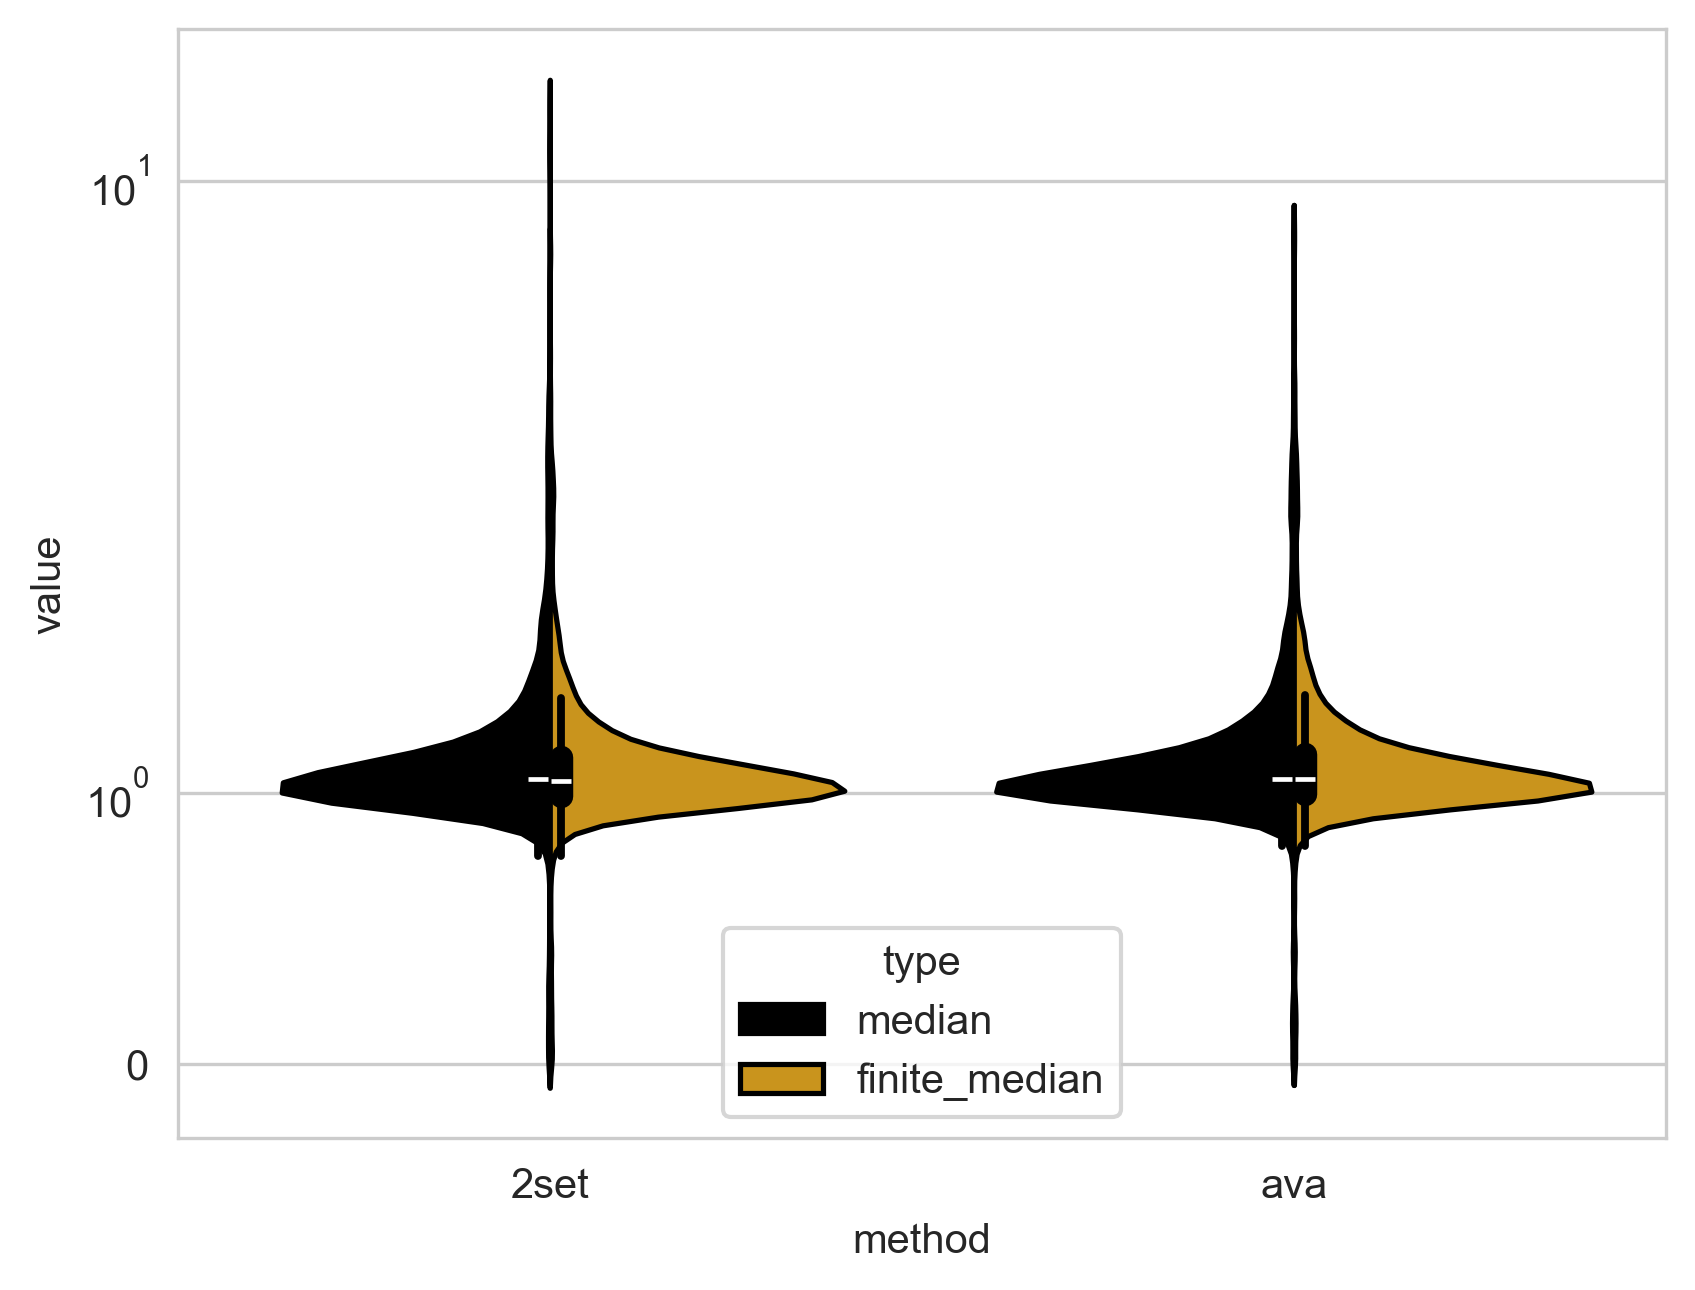

In [17]:
fig, ax = plt.subplots(dpi=300)
ax.set_yscale("symlog")
# sns.boxenplot(data=melted, x="method", y="value", hue="type", ax=ax)
sns.violinplot(data=melted, x="method", y="value", hue="type", ax=ax, split=True)


In [18]:
melted.groupby(["method", "type"]).describe()

/Users/michael/sw/miniforge3/envs/lrge/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


value                                          \
                       count      mean       std       min       25%   
method type                                                            
2set   finite_median  3370.0  1.095779  0.283122  0.009570  0.987273   
       median         3370.0       inf       NaN  0.009571  0.990112   
ava    finite_median  3370.0  1.112027  0.304319  0.010842  0.996758   
       median         3370.0  1.112027  0.304319  0.010842  0.996758   

                                                    
                           50%       75%       max  
method type                                         
2set   finite_median  1.045777  1.132795  7.165411  
       median         1.053746  1.149930       inf  
ava    finite_median  1.052399  1.143230  7.982896  
       median         1.052399  1.143230  7.982896

In [19]:
# show where medians are different
medians_df[medians_df["median"] != medians_df["finite_median"]]

,,median,finite_median,percentile_10.0,percentile_11.0,percentile_12.0,percentile_13.0,percentile_14.0,percentile_15.0,percentile_16.0,percentile_17.0,...,finite_percentile_80.0,finite_percentile_81.0,finite_percentile_82.0,finite_percentile_83.0,finite_percentile_84.0,finite_percentile_85.0,finite_percentile_86.0,finite_percentile_87.0,finite_percentile_88.0,finite_percentile_89.0
accession,method,,,,,,,,,,,,,,,,,,,,,
DRR072240,2set,2.054183,2.002263,1.229393,1.252098,1.271330,1.291735,1.308739,1.332773,1.354916,1.380756,...,3.464128,3.574191,3.715098,3.856879,4.010541,4.174279,4.323338,4.581628,4.854420,5.204001
DRR126367,2set,1.213236,1.210372,0.840811,0.856846,0.877551,0.892100,0.905107,0.926163,0.938344,0.949326,...,1.562928,1.577023,1.597867,1.626275,1.653030,1.681982,1.709822,1.741535,1.764668,1.799387
DRR126418,2set,1.300121,1.288371,0.778657,0.806174,0.827361,0.842484,0.857766,0.876551,0.892555,0.906880,...,1.823299,1.865737,1.892464,1.933296,1.975202,2.029109,2.082341,2.135328,2.198890,2.290321
DRR126420,2set,1.244136,1.235322,0.737193,0.763746,0.782594,0.803667,0.817590,0.834624,0.850784,0.863143,...,1.803195,1.831257,1.877238,1.927037,1.979025,2.038158,2.102541,2.174863,2.247668,2.352927
DRR140496,2set,1.713546,1.649098,0.951634,0.982294,1.013833,1.045493,1.068196,1.094328,1.116657,1.135421,...,2.602667,2.680902,2.740690,2.826057,2.937980,3.035293,3.159550,3.281480,3.448460,3.699141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR9900640,2set,1.662074,1.442582,0.849754,0.866964,0.888559,0.905616,0.925244,0.941122,0.958885,0.977672,...,2.439271,2.545584,2.653178,2.837963,3.067322,3.280515,3.352633,3.412153,3.467340,3.516133
SRR9901958,2set,1.311531,1.261851,0.619731,0.649542,0.674620,0.700439,0.725294,0.742974,0.762021,0.792364,...,1.972891,2.024584,2.051711,2.086799,2.158831,2.242515,2.477408,2.543327,2.595426,2.671317
SRR9970116,2set,1.003228,1.000054,0.579378,0.602517,0.627569,0.650712,0.668107,0.694427,0.717782,0.738859,...,1.280975,1.295232,1.310884,1.328496,1.343088,1.360621,1.379615,1.399742,1.425138,1.448095


In [58]:
data = []
percentile_bins = [5, 10, 20, 30, 40, 50]
for percentile in percentile_bins:
    low_percentile = float(50 - percentile * 0.6)
    high_percentile = float(50 + percentile * 0.4)
    for (acc, method), row in medians_df.iterrows():
        low_val = row[f"percentile_{low_percentile}"]
        low_finite_val = row[f"finite_percentile_{low_percentile}"]
        high_val = row[f"percentile_{high_percentile}"]
        high_finite_val = row[f"finite_percentile_{high_percentile}"]
        all_contains_one = low_val <= 1.0 <= high_val
        finite_contains_one = low_finite_val <= 1.0 <= high_finite_val
        gsize = true_sizes[acc]
        data.append([acc, method, percentile, low_percentile, high_percentile, 'all', low_val, high_val, all_contains_one, gsize])
        data.append([acc, method, percentile, low_percentile, high_percentile, 'finite', low_finite_val, high_finite_val, finite_contains_one, gsize])


In [59]:
percentile_df = pd.DataFrame(data, columns=["accession", "method", "percentile_bin", "low_percentile", "high_percentile", "type", "low", "high", "contains_one", "true_size"])
percentile_df

,accession,method,percentile_bin,low_percentile,high_percentile,type,low,high,contains_one,true_size
0,DRR072240,2set,5,47.0,52.0,all,1.971322,2.102892,False,2877864
1,DRR072240,2set,5,47.0,52.0,finite,1.931195,2.060392,False,2877864
2,DRR072240,ava,5,47.0,52.0,all,1.937992,2.049675,False,2877864
3,DRR072240,ava,5,47.0,52.0,finite,1.937992,2.049675,False,2877864
4,DRR126367,2set,5,47.0,52.0,all,1.191457,1.227496,False,3320462
...,...,...,...,...,...,...,...,...,...,...
80875,SRR9970117,ava,50,20.0,70.0,finite,0.876487,1.129128,True,4891702
80876,SRR9988395,2set,50,20.0,70.0,all,0.840101,1.475442,True,6835731
80877,SRR9988395,2set,50,20.0,70.0,finite,0.825733,1.385458,True,6835731
80878,SRR9988395,ava,50,20.0,70.0,all,0.853353,1.345940,True,6835731


/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_2999/1000224015.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


[Text(0, 0, '47-52'),
 Text(1, 0, '44-54'),
 Text(2, 0, '38-58'),
 Text(3, 0, '32-62'),
 Text(4, 0, '26-66'),
 Text(5, 0, '20-70')]

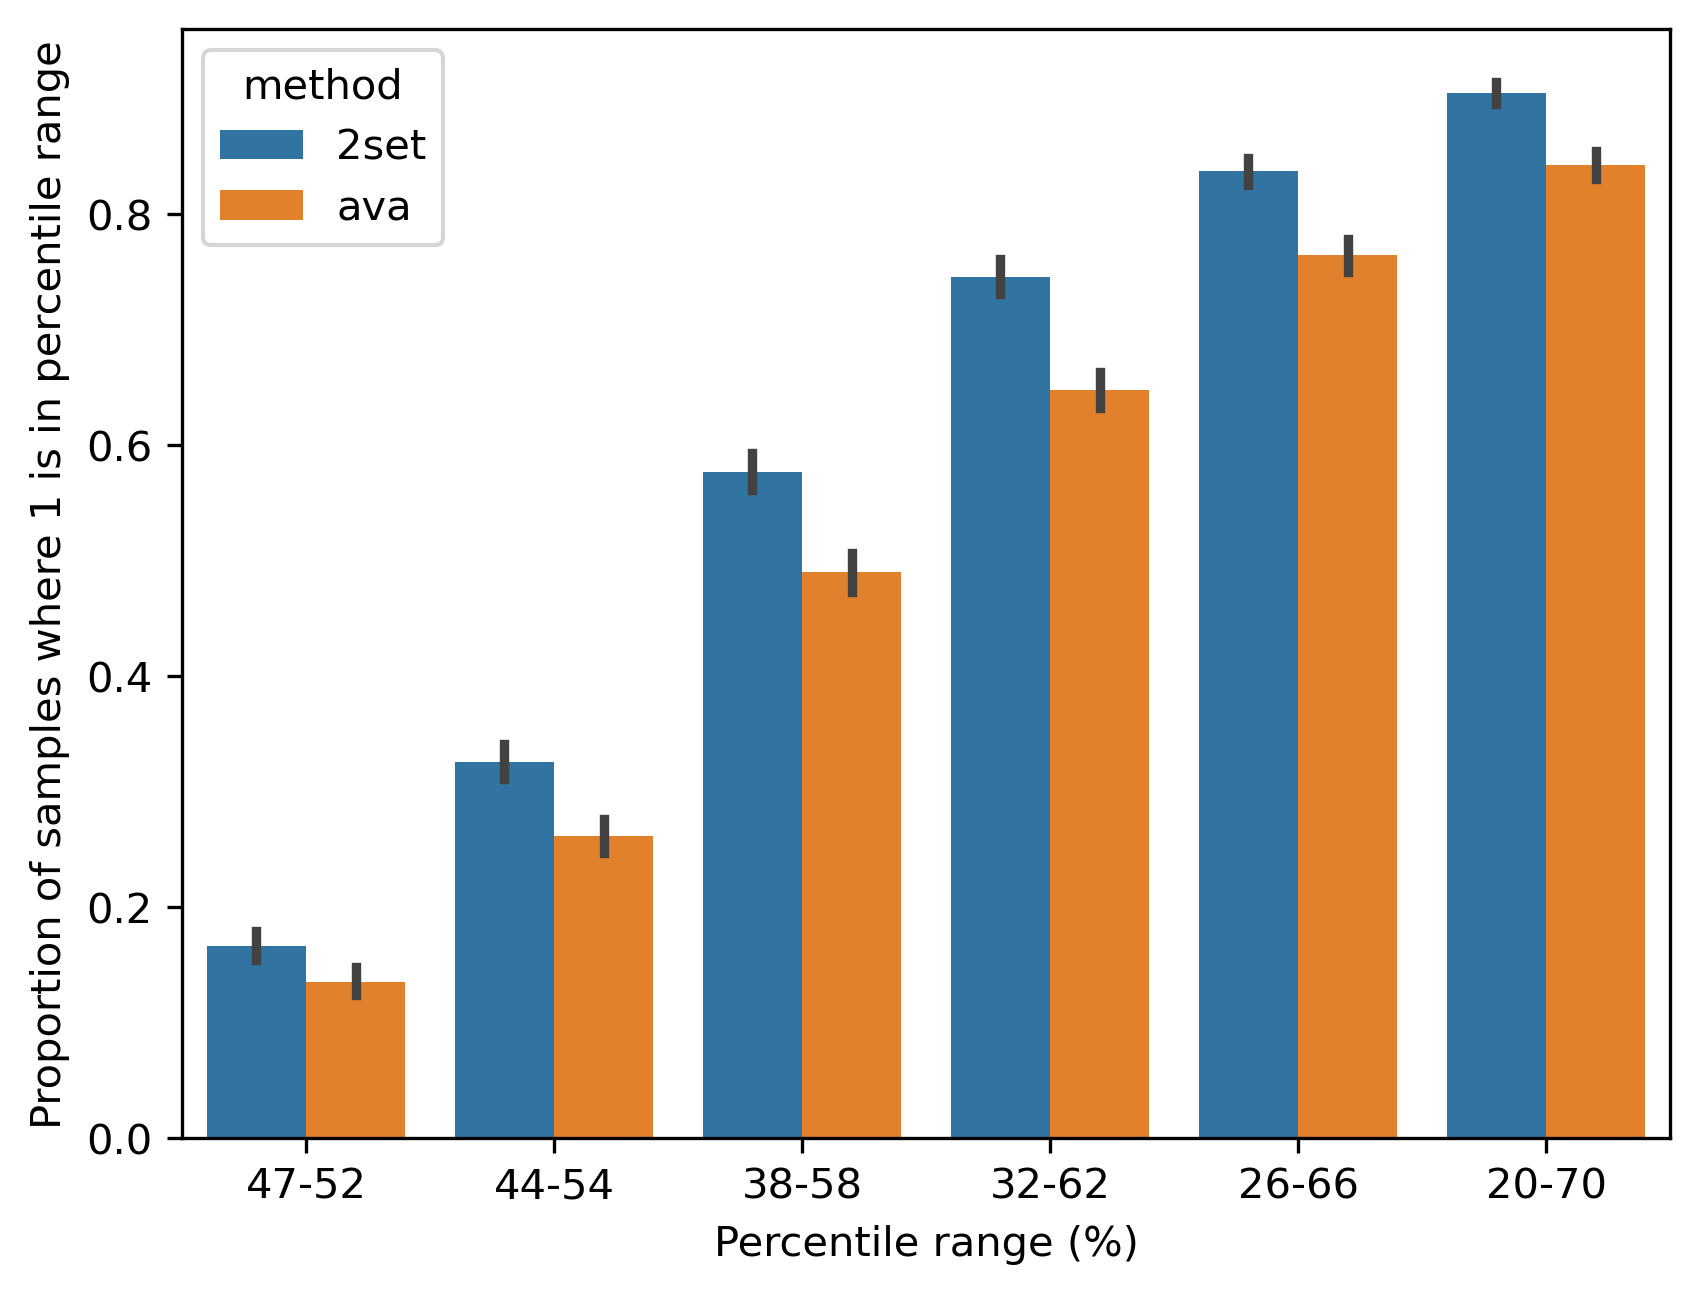

In [60]:
# on the xaxis, we plot the percentile bins, on the yaxis we plot the proportion of samples with True in the contains_one column
# and we hue on the method
d = percentile_df.query("type == 'finite'")
fig, ax = plt.subplots(dpi=300)
sns.barplot(data=d, x="percentile_bin", y="contains_one", hue="method", ax=ax)
ax.set_ylabel("Proportion of samples where 1 is in percentile range")
ax.set_xlabel("Percentile range (%)")
xticks = percentile_bins
xticklabels = [f"{50 - p * 0.6:g}-{50 + p * 0.4:g}" for p in percentile_bins]
# ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

In [61]:
# plot where each genome is a dot, the x axis is genome size and the y axis is |IQR|/GS
percentile_df["iqr"] = percentile_df["high"] - percentile_df["low"]
percentile_df["|IQR|/GS"] = percentile_df["iqr"] / percentile_df["true_size"]

/Users/michael/sw/miniforge3/envs/lrge/lib/python3.13/site-packages/seaborn/relational.py:733: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


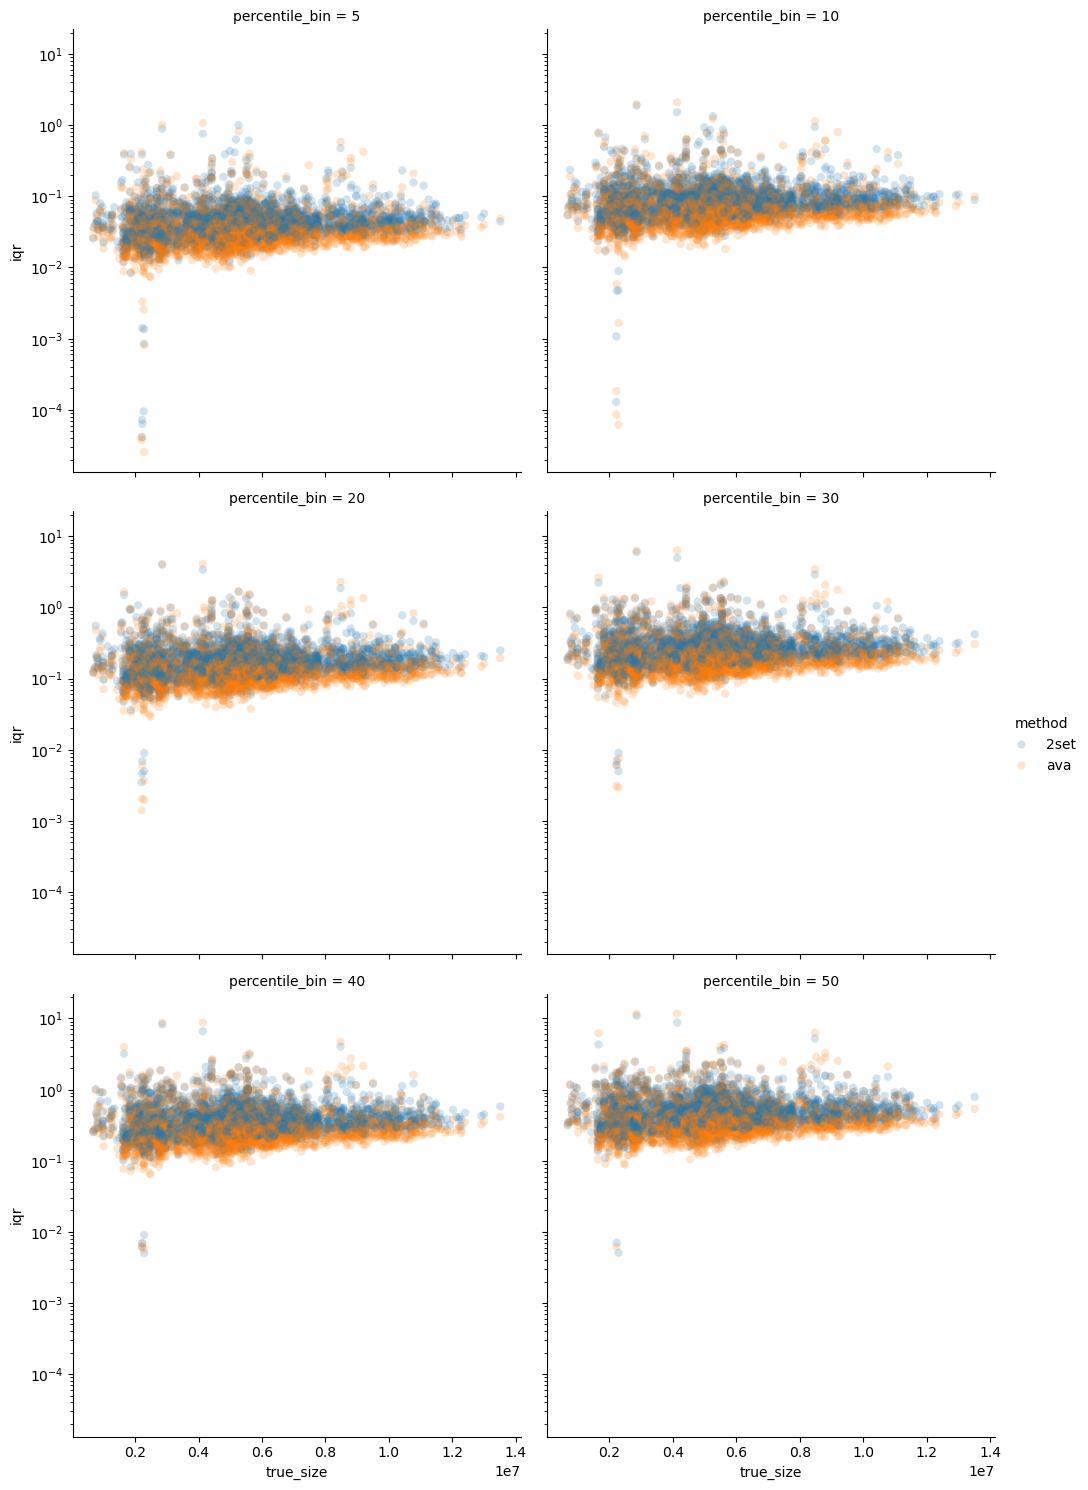

In [62]:
# fig, ax = plt.subplots(dpi=300)
d = percentile_df.query("type == 'finite'")
g = sns.relplot(
    data=d,
    x="true_size",
    y="iqr",
    hue="method",
    col="percentile_bin",
    ax=ax,
    col_wrap=2,
    linewidth=0,
    alpha=0.2,
)
g.set(yscale="log")

In [63]:
print(d.groupby(["method", "percentile_bin"])[["iqr"]].describe().to_csv())

,,iqr,iqr,iqr,iqr,iqr,iqr,iqr,iqr
,,count,mean,std,min,25%,50%,75%,max
method,percentile_bin,,,,,,,,
2set,5,3370.0,0.04870701751290118,0.04358360927164875,0.0,0.03221067621380036,0.04101254285881156,0.052631181841314684,1.0028564112547695
2set,10,3370.0,0.09683587464053761,0.08008475229522427,0.0,0.06474890142884526,0.08165158311378745,0.10454993759831108,1.882080002577566
2set,20,3370.0,0.19451448160495766,0.15222891399699653,0.0,0.13081005368188192,0.16493616464573074,0.2119157121579306,3.9864899259580406
2set,30,3370.0,0.297286929802593,0.22482603994481024,0.0,0.19942987644230872,0.25156990053079853,0.3214762814233087,5.98682172201499
2set,40,3370.0,0.40838829141672894,0.30185736134037744,0.005015274145443501,0.2732889175620563,0.3457628653135539,0.4425695177254393,8.27798134233785
2set,50,3370.0,0.5330227029004698,0.3861705667726691,0.005070808828867601,0.3596840926357502,0.4547585962013234,0.5839692576352914,10.902559322770783
ava,5,3370.0,0.03962705907067806,0.04355290054148419,0

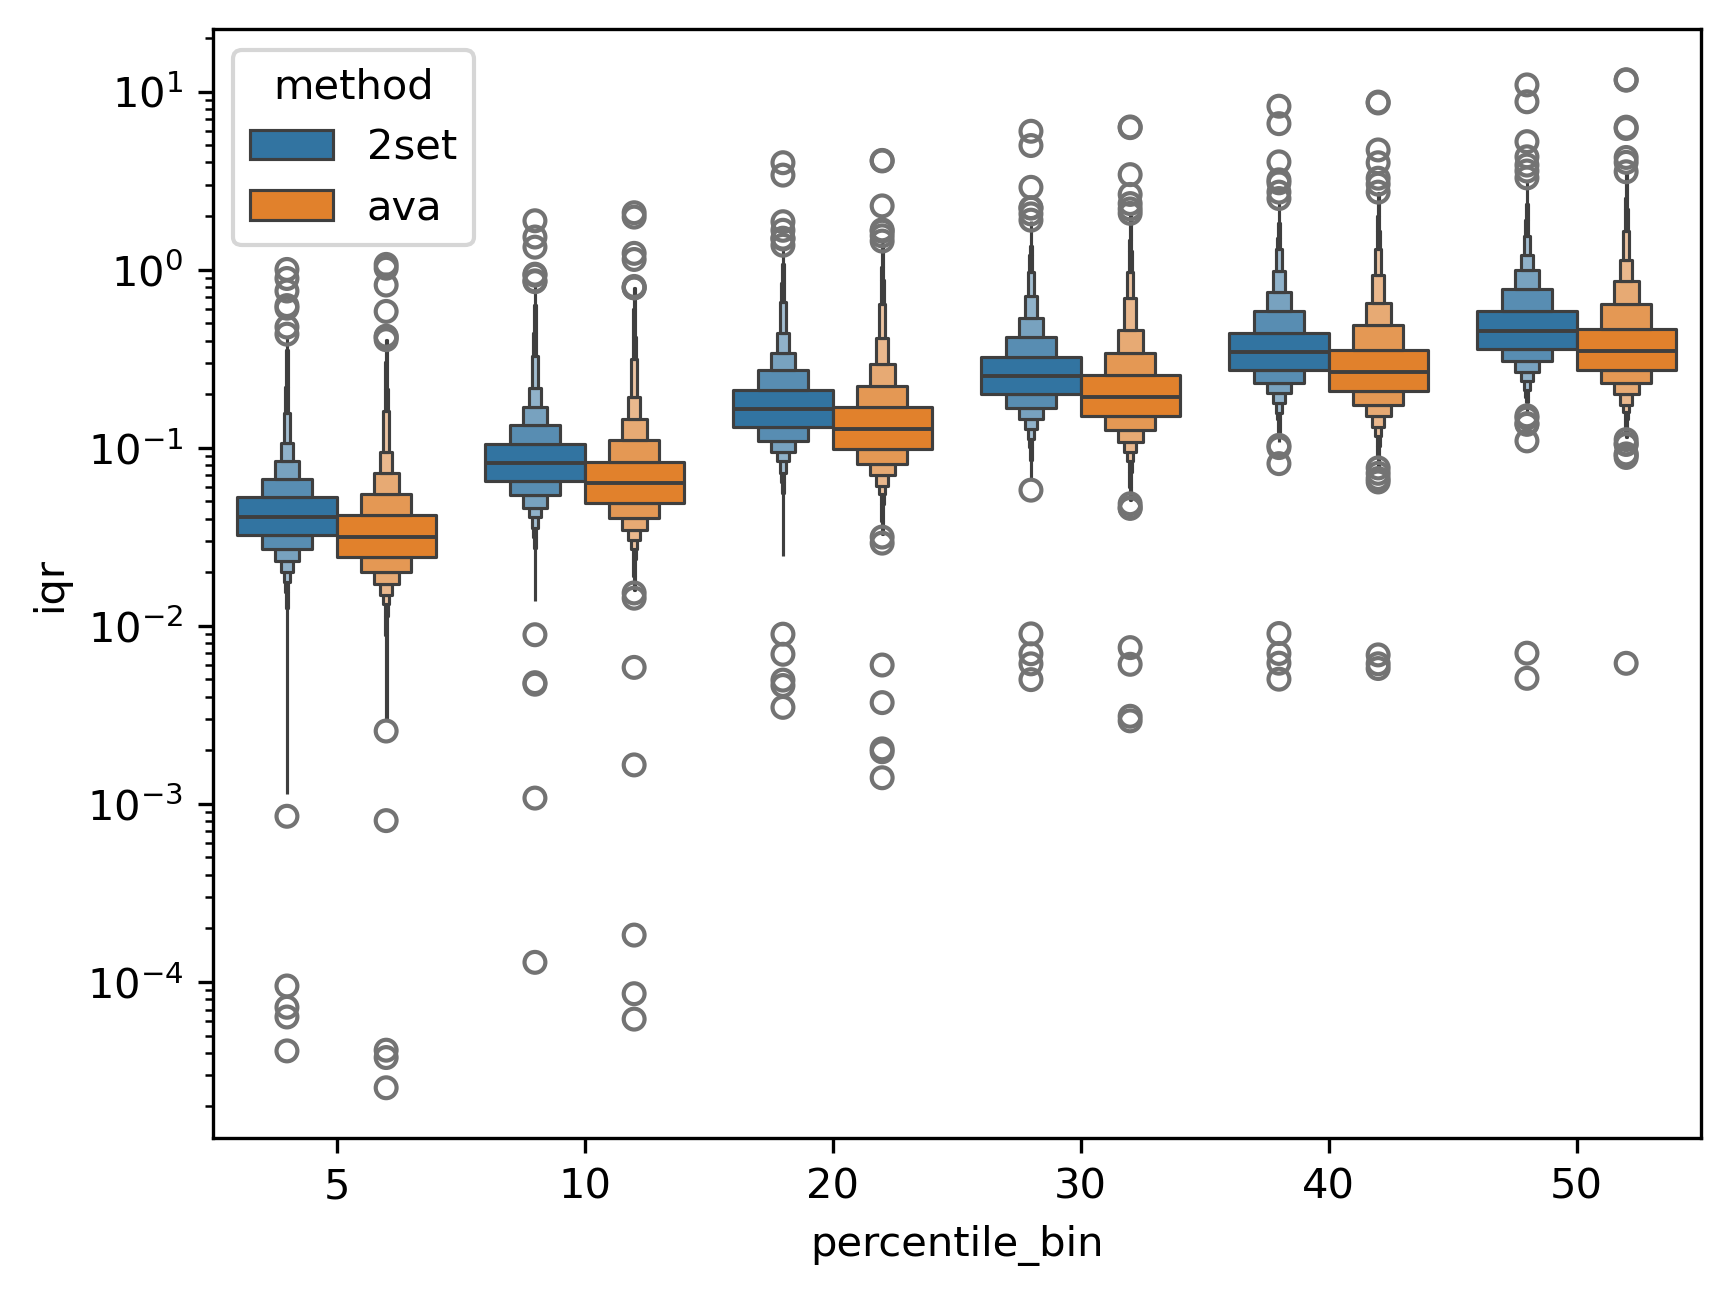

In [64]:
fig, ax = plt.subplots(dpi=300)
sns.boxenplot(data=d, x="percentile_bin", y="iqr", hue="method", ax=ax)
ax.set_yscale("log")

In [65]:
# make a table grouped by method and percentile bin with the proportion of samples that 
# have a value of True for contains_one and the mean IQR
# print(percentile_df.groupby(["method", "percentile_bin"])["contains_one"].mean().unstack().to_csv())
iqr_summary = percentile_df.groupby(["method", "percentile_bin"])[["contains_one", "iqr"]].mean().sort_values("percentile_bin")
print(iqr_summary.to_csv())

method,percentile_bin,contains_one,iqr
2set,5,0.16246290801186944,0.05232331245088918
ava,5,0.13531157270029673,0.03962705907067806
2set,10,0.3148367952522255,0.10357707147160433
ava,10,0.26142433234421364,0.0791450935140217
2set,20,0.5675074183976261,0.2073619360789513
ava,20,0.48991097922848664,0.15973344466388908
2set,30,0.7378338278931751,0.315746553383862
ava,30,0.6480712166172107,0.2444440082134673
2set,40,0.8327893175074184,0.43461836928838904
ava,40,0.7649851632047477,0.3362785023692716
2set,50,0.9020771513353115,0.5713445298218071
ava,50,0.842433234421365,0.44116072988856175



<Axes: xlabel='iqr', ylabel='contains_one'>

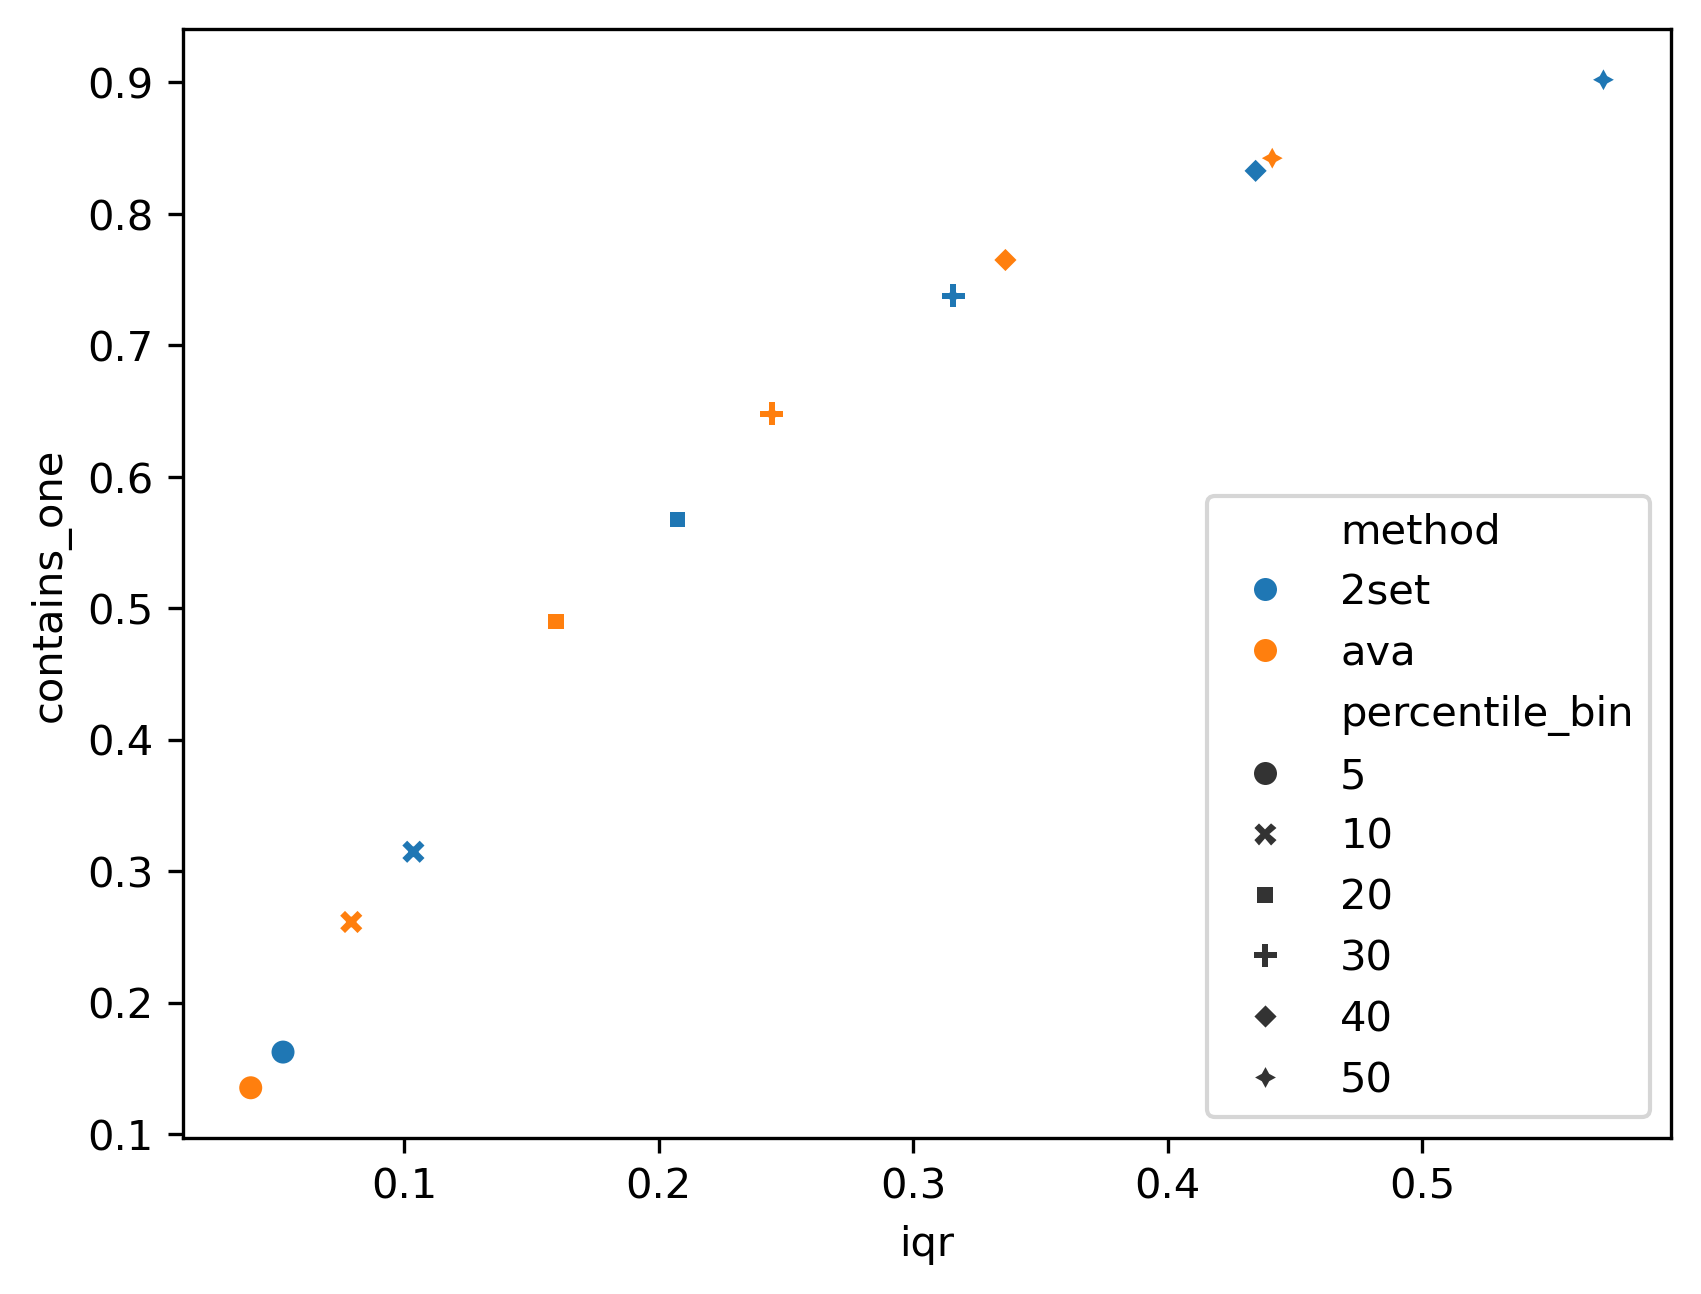

In [66]:
fig, ax = plt.subplots(dpi=300)
sns.scatterplot(data=iqr_summary, x="iqr", y="contains_one", hue="method", ax=ax, style="percentile_bin")

Text(0, 0.5, 'Proportion of samples where 1 is in percentile range')

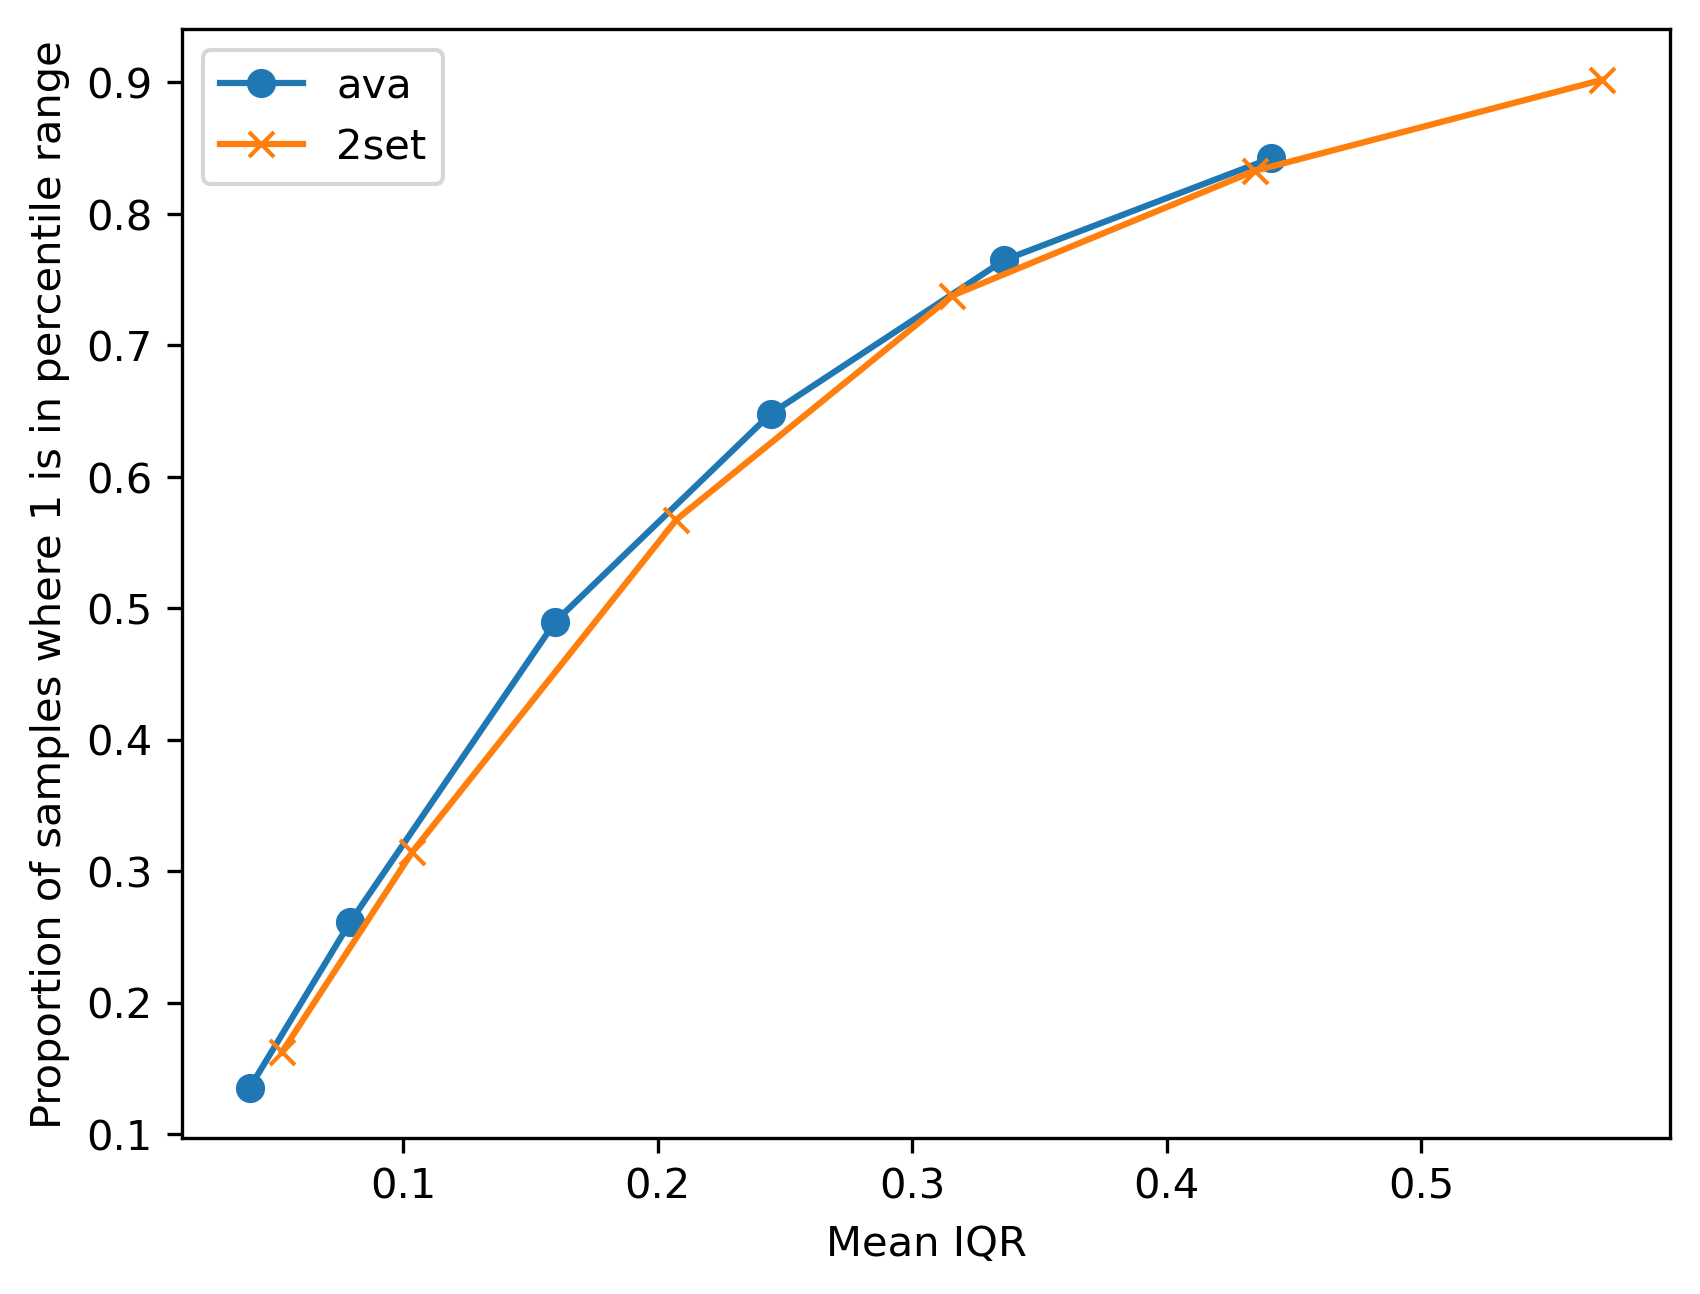

In [67]:
fig, ax = plt.subplots(dpi=300)
ax.plot("iqr", "contains_one", data=iqr_summary.query("method == 'ava'"), marker="o")
ax.plot("iqr", "contains_one", data=iqr_summary.query("method == '2set'"), marker="x")
ax.legend(["ava", "2set"])
ax.set_xlabel("Mean IQR")
ax.set_ylabel("Proportion of samples where 1 is in percentile range")

We could potentially investigate this using a sliding window of 50% ranges going from [1,51], ...[49,99]     - I realise a bit of a pain to do

In [20]:

perc_range = np.arange(1, 100, 1.0)
# function to apply to each group. it takes the median of the relative size and the median of the finite relative sizes
# it also calculates the percentiles of the relative sizes in 2.5% steps
def f2(group):
    relsizes = group["relative_size"]
    median = relsizes.median()
    finite_ixs = np.isfinite(relsizes)
    finite = relsizes[finite_ixs]
    finite_median = finite.median()
    percentiles = np.percentile(finite, perc_range)
    return pd.Series([finite_median] + list(percentiles))

In [21]:
range_df = groups.apply(f2)
range_df.columns = ["median"] + [f"percentile_{i}" for i in perc_range]

/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_67596/3193635748.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  range_df = groups.apply(f2)


In [22]:
data = []
rng = 50
percentile_bins = list(range(1, 50))
for percentile in map(float, percentile_bins):
    low_percentile = percentile
    high_percentile = percentile + rng
    for (acc, method), row in range_df.iterrows():
        low_val = row[f"percentile_{low_percentile}"]
        high_val = row[f"percentile_{high_percentile}"]
        contains_one = low_val <= 1.0 <= high_val
        gsize = true_sizes[acc]
        data.append([acc, method, percentile, low_percentile, high_percentile, low_val, high_val, contains_one, gsize])

In [23]:
rng_scan = pd.DataFrame(data, columns=["accession", "method", "percentile_bin", "low_percentile", "high_percentile", "low", "high", "contains_one", "true_size"])

In [24]:
rng_scan["IQR"] = rng_scan["high"] - rng_scan["low"]
rng_scan

,accession,method,percentile_bin,low_percentile,high_percentile,low,high,contains_one,true_size,IQR
0,DRR072240,2set,1.0,1.0,51.0,0.551059,2.030053,True,2877864,1.478995
1,DRR072240,ava,1.0,1.0,51.0,0.785659,2.023555,True,2877864,1.237897
2,DRR126367,2set,1.0,1.0,51.0,0.399558,1.216473,True,3320462,0.816915
3,DRR126367,ava,1.0,1.0,51.0,0.696912,1.231407,True,3320462,0.534495
4,DRR126418,2set,1.0,1.0,51.0,0.353328,1.301042,True,3138474,0.947714
...,...,...,...,...,...,...,...,...,...,...
330255,SRR9970116,ava,49.0,49.0,99.0,0.999329,3.312858,True,4028093,2.313529
330256,SRR9970117,2set,49.0,49.0,99.0,1.009194,2.308226,False,4891702,1.299032
330257,SRR9970117,ava,49.0,49.0,99.0,1.002349,2.356872,False,4891702,1.354523
330258,SRR9988395,2set,49.0,49.0,99.0,1.108842,9.329338,False,6835731,8.220496


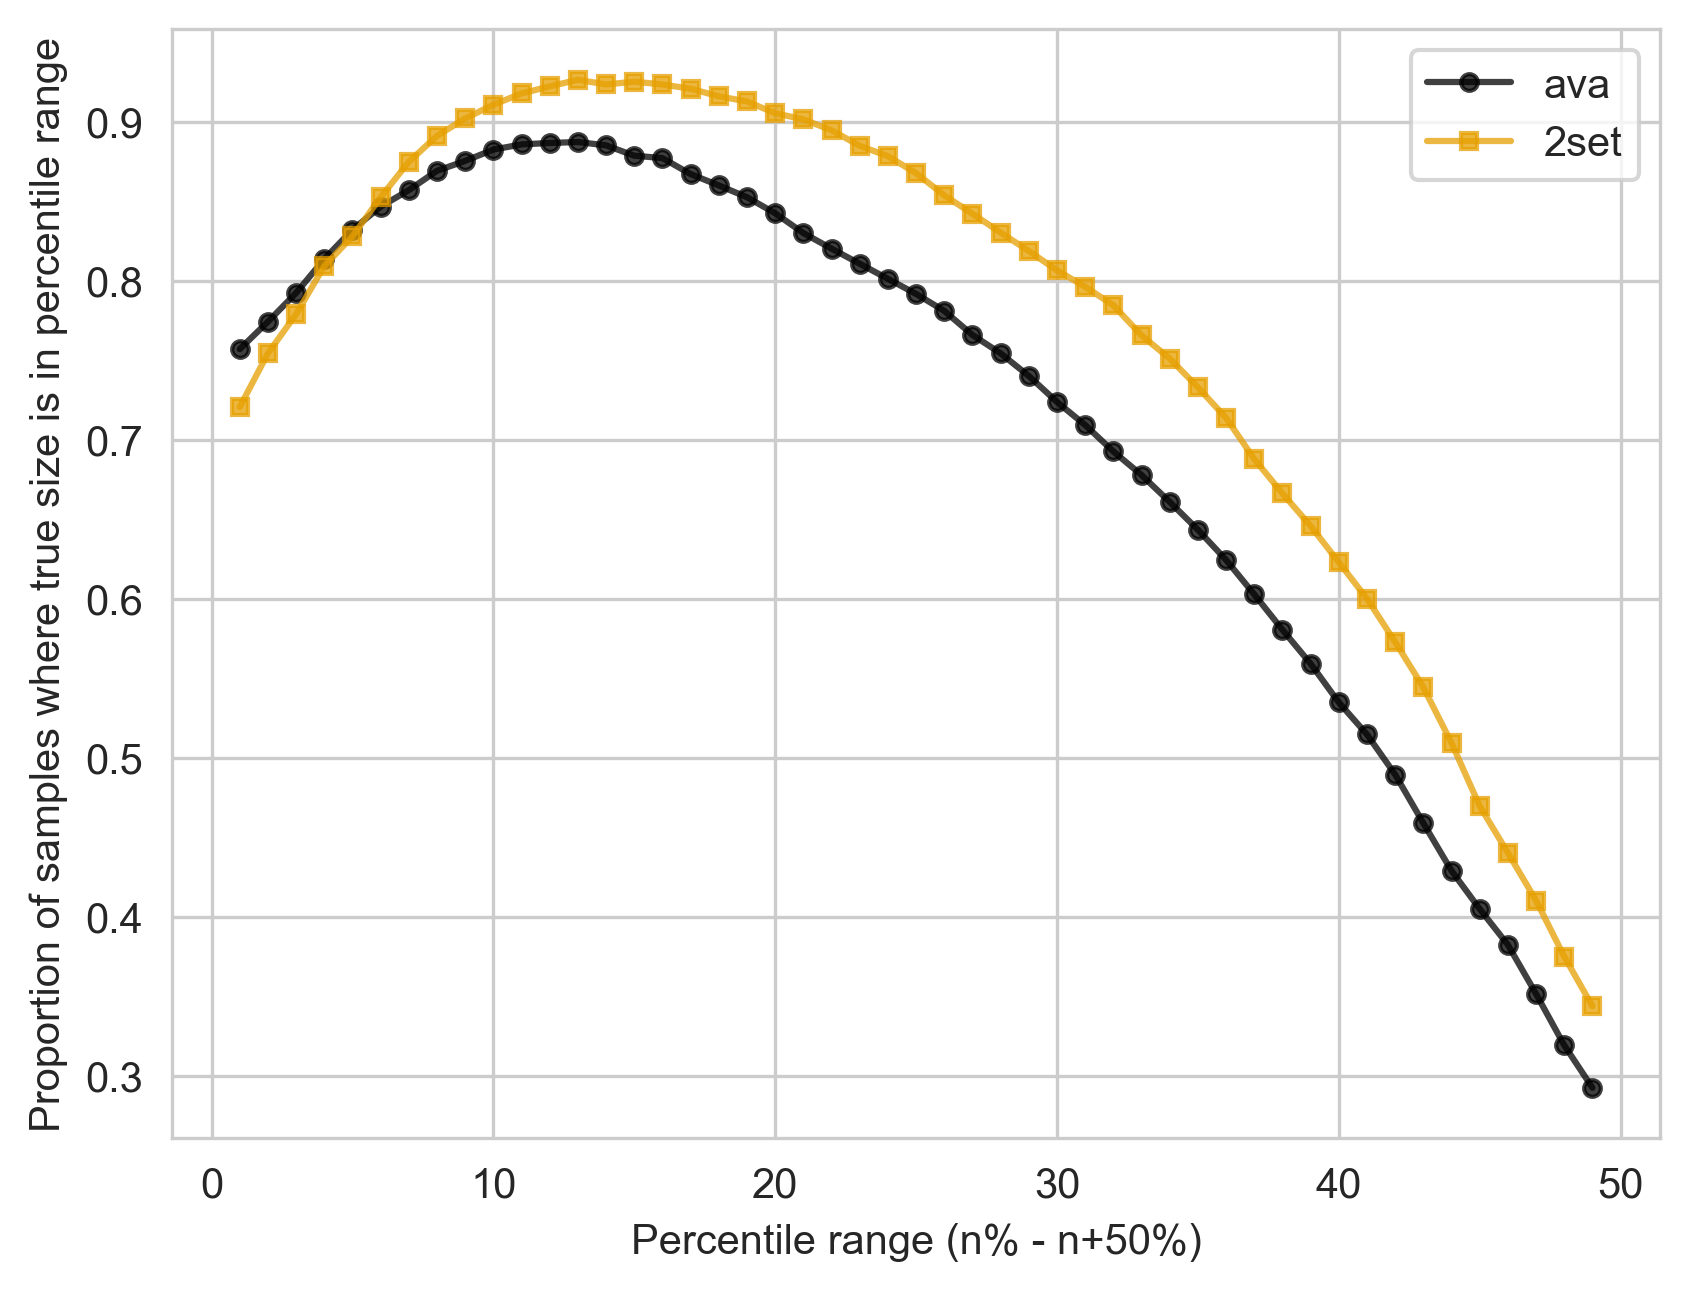

In [39]:
fig, ax = plt.subplots(dpi=300)
d = rng_scan.groupby(["method", "percentile_bin"])[["contains_one", "IQR"]].mean().reset_index()
ax.plot("percentile_bin", "contains_one", data=d.query("method == 'ava'"), marker="o", markersize=4, alpha=0.75)
ax.plot("percentile_bin", "contains_one", data=d.query("method == '2set'"), marker="s", markersize=4, alpha=0.75)
ax.legend(["ava", "2set"])
ax.set_xlabel("Percentile range (n% - n+50%)")
ax.set_ylabel("Proportion of samples where true size is in percentile range")
fig.savefig(FIGURES / "percentile_range_scan.pdf")

In [36]:
# get the maximum IQR and contains_one for each method
max_ix = d.groupby("method")["contains_one"].idxmax()
print(d.loc[max_ix].to_markdown(index=False))

| method   |   percentile_bin |   contains_one |      IQR |
|:---------|-----------------:|---------------:|---------:|
| 2set     |               13 |       0.926409 | 0.530852 |
| ava      |               13 |       0.88724  | 0.444098 |


In [37]:
min_ix = d.groupby("method")["IQR"].idxmin()
print(d.loc[min_ix].to_markdown(index=False))

| method   |   percentile_bin |   contains_one |      IQR |
|:---------|-----------------:|---------------:|---------:|
| 2set     |               16 |       0.923442 | 0.524403 |
| ava      |               17 |       0.867062 | 0.436132 |


In [38]:
d.query("percentile_bin == 15")

,method,percentile_bin,contains_one,IQR
14,2set,15.0,0.925223,0.525129
63,ava,15.0,0.878635,0.437687


Exploring how query size impacts CI

In [77]:
df = pd.read_csv("lrge_2set_per_read_estimates.csv", low_memory=False)
df

FileNotFoundError: [Errno 2] No such file or directory: 'lrge_2set_per_read_estimates.csv'

In [ ]:
df['relative_size'] = df['estimate'] / df['accession'].map(true_sizes)

In [ ]:
groups = df.groupby(["accession", "Q"])

In [ ]:
perc_range = np.arange(1, 100, 1.0)
# function to apply to each group. it takes the median of the relative size and the median of the finite relative sizes
# it also calculates the percentiles of the relative sizes in 2.5% steps
def f2(group):
    relsizes = group["relative_size"]
    finite_ixs = np.isfinite(relsizes)
    finite = relsizes[finite_ixs]
    finite_median = finite.median()
    percentiles = np.percentile(finite, perc_range)
    return pd.Series([finite_median] + list(percentiles))

In [ ]:
range_df = groups.apply(f2)
range_df.columns = ["median"] + [f"percentile_{i}" for i in perc_range]

/tmp/ipykernel_460659/3193635748.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  range_df = groups.apply(f2)


In [ ]:
data = []
rng = 50
percentile_bins = list(range(1, 50))
for percentile in map(float, percentile_bins):
    low_percentile = percentile
    high_percentile = percentile + rng
    for (acc, Q), row in range_df.iterrows():
        low_val = row[f"percentile_{low_percentile}"]
        high_val = row[f"percentile_{high_percentile}"]
        contains_one = low_val <= 1.0 <= high_val
        gsize = true_sizes[acc]
        data.append([acc, Q, percentile, low_percentile, high_percentile, low_val, high_val, contains_one, gsize])

In [ ]:
rng_scan = pd.DataFrame(data, columns=["accession", "Q", "percentile_bin", "low_percentile", "high_percentile", "low", "high", "contains_one", "true_size"])

In [ ]:
rng_scan["IQR"] = rng_scan["high"] - rng_scan["low"]
rng_scan

,accession,Q,percentile_bin,low_percentile,high_percentile,low,high,contains_one,true_size,IQR
0,DRR424517,10000,1.0,1.0,51.0,0.082490,0.877502,False,6107920,0.795011
1,DRR424517,20000,1.0,1.0,51.0,0.081682,0.891387,False,6107920,0.809705
2,DRR424517,30000,1.0,1.0,51.0,0.083296,0.909422,False,6107920,0.826126
3,DRR424517,40000,1.0,1.0,51.0,0.085987,0.907964,False,6107920,0.821977
4,DRR424517,50000,1.0,1.0,51.0,0.082115,0.911574,False,6107920,0.829459
...,...,...,...,...,...,...,...,...,...,...
3425,SRR9970116,30000,49.0,49.0,99.0,0.995888,3.118200,True,4028093,2.122313
3426,SRR9970116,40000,49.0,49.0,99.0,0.992028,2.856837,True,4028093,1.864809
3427,SRR9970116,50000,49.0,49.0,99.0,1.002916,3.313728,False,4028093,2.310812
3428,SRR9970116,100000,49.0,49.0,99.0,1.001114,3.180273,False,4028093,2.179159


Text(0, 0.5, 'Proportion of samples where 1 is in percentile range')

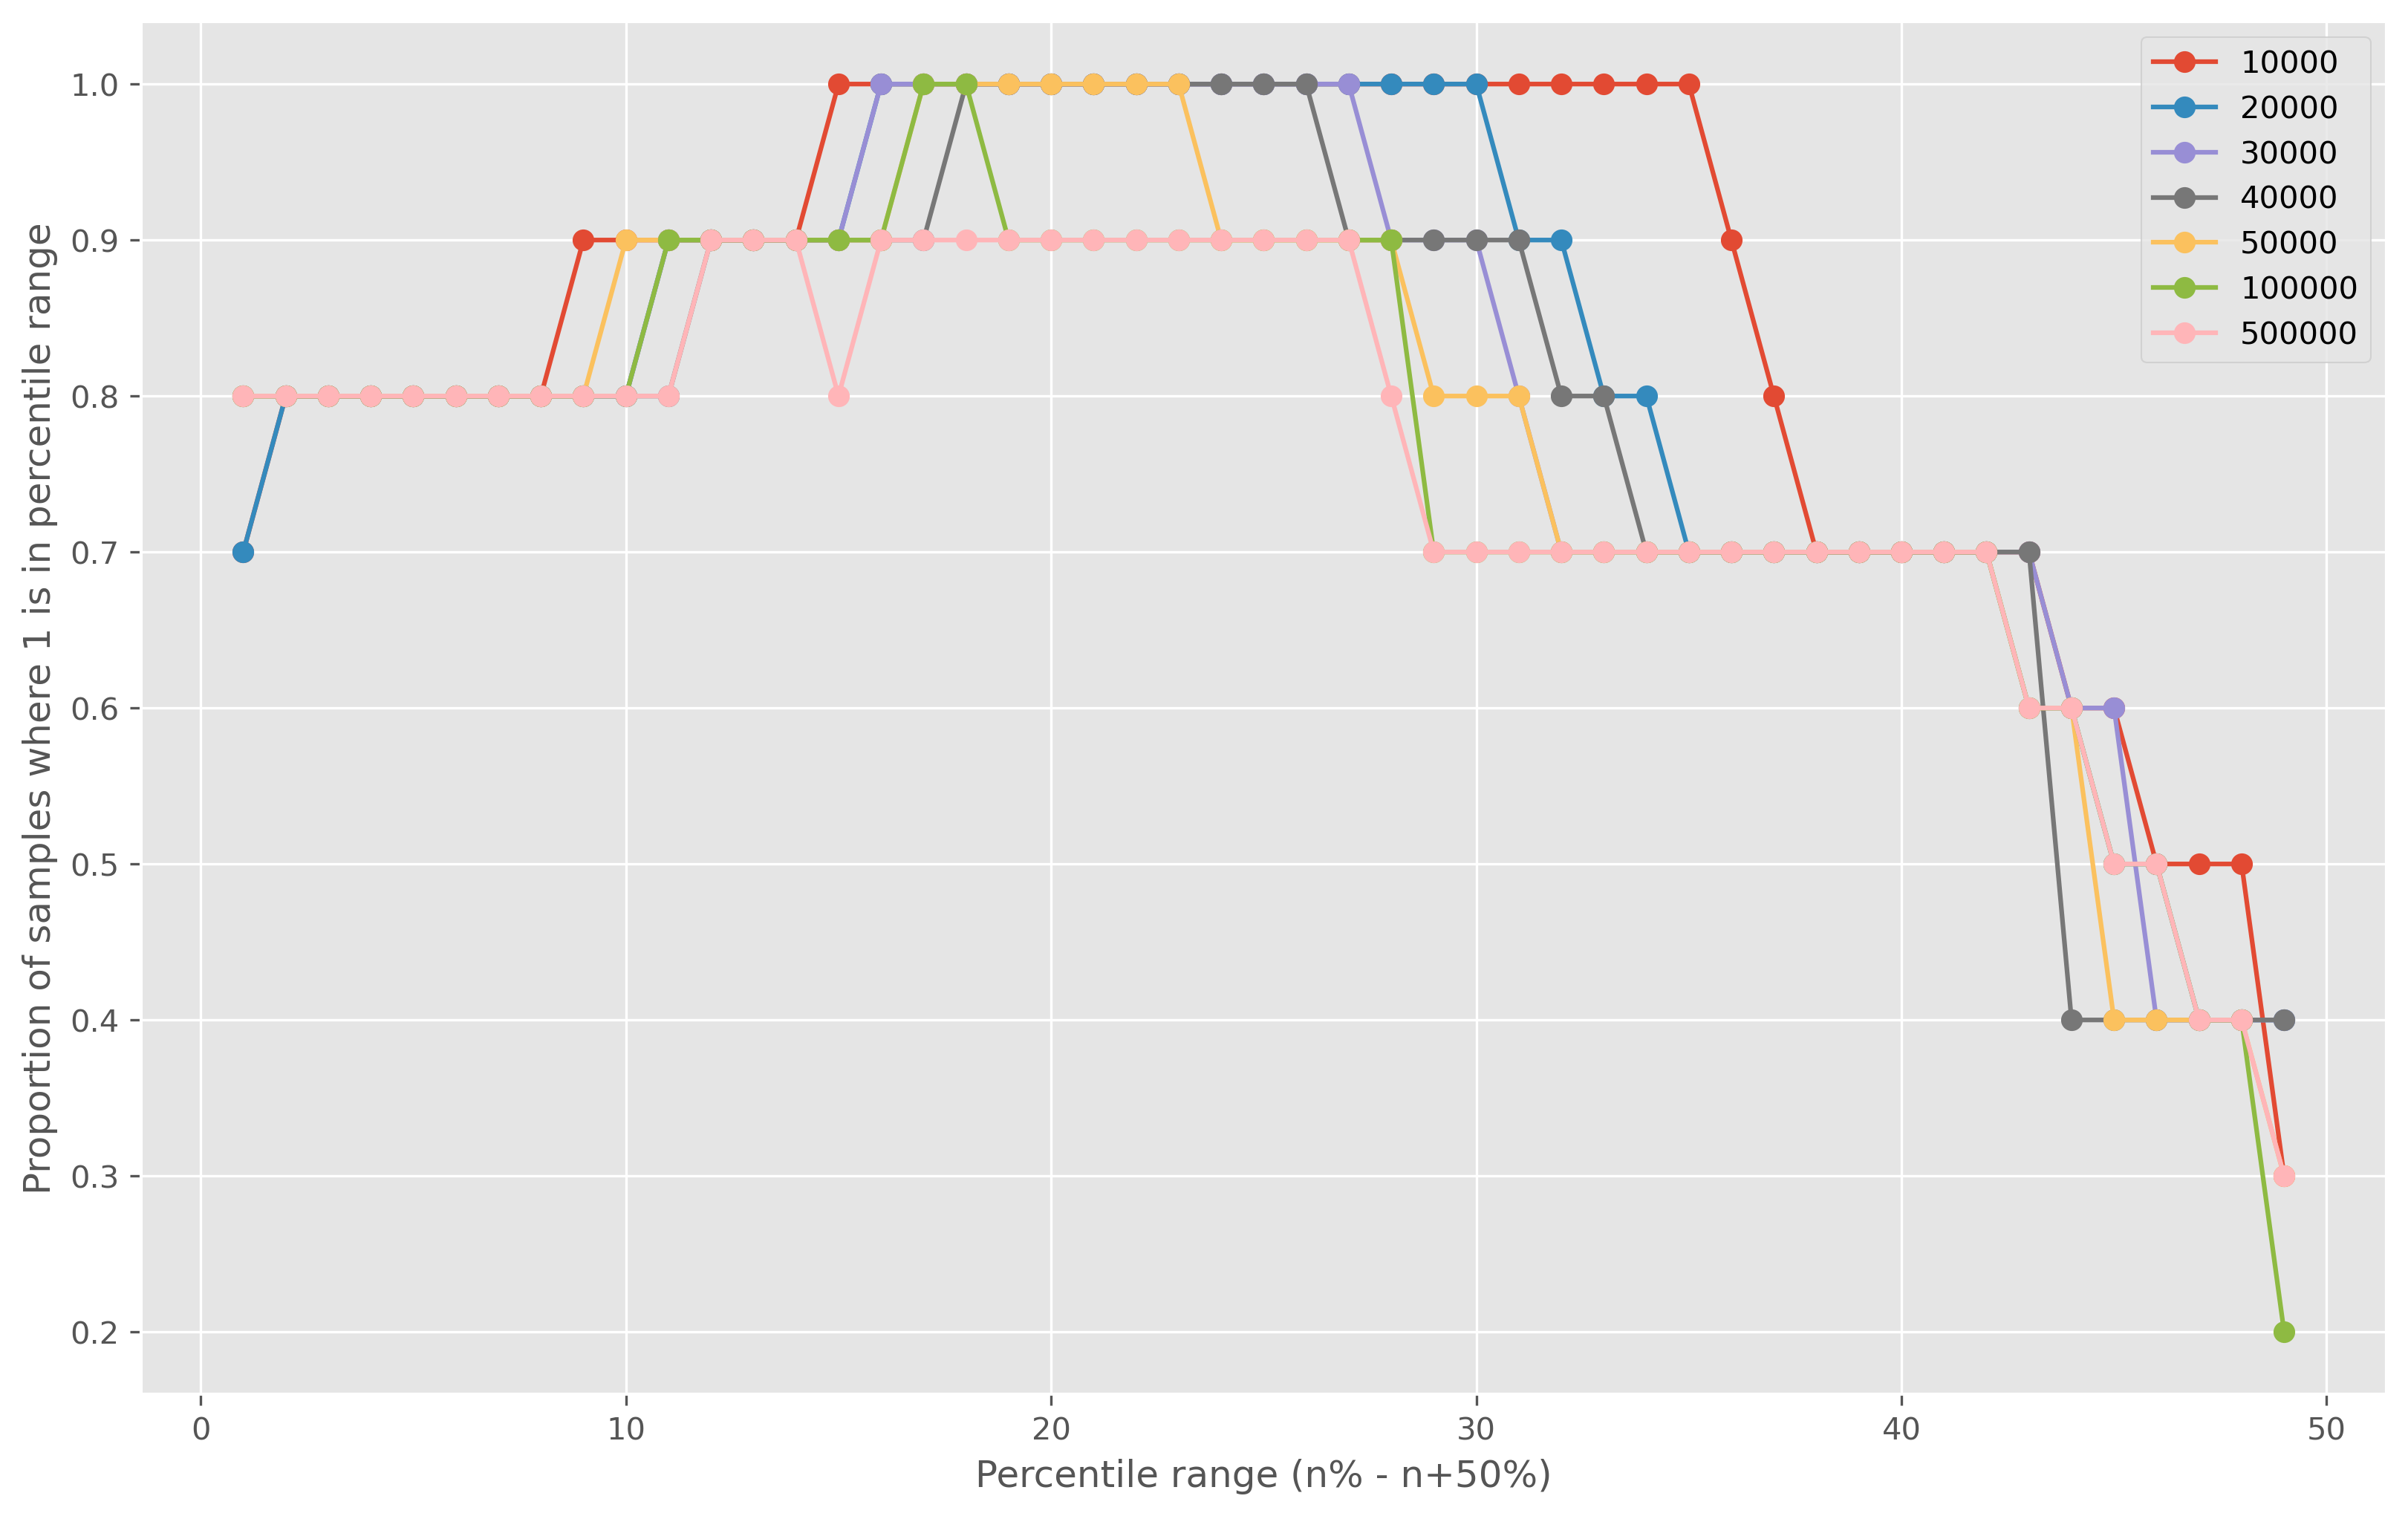

In [ ]:
fig, ax = plt.subplots(dpi=300)
d = rng_scan.groupby(["Q", "percentile_bin"])[["contains_one", "IQR"]].mean().reset_index()
for q in d["Q"].unique():
    ax.plot("percentile_bin", "contains_one", data=d.query("Q == @q"), marker="o")

ax.legend(d["Q"].unique())
ax.set_xlabel("Percentile range (n% - n+50%)")
ax.set_ylabel("Proportion of samples where 1 is in percentile range")

[Text(0, 0.1, '0.1'),
 Text(0, 0.25, '0.25'),
 Text(0, 0.5, '0.5'),
 Text(0, 0.8, '0.8'),
 Text(0, 0.9, '0.9'),
 Text(0, 1.0, '1'),
 Text(0, 2.0, '2'),
 Text(0, 3.0, '3'),
 Text(0, 4.0, '4'),
 Text(0, 5.0, '5')]

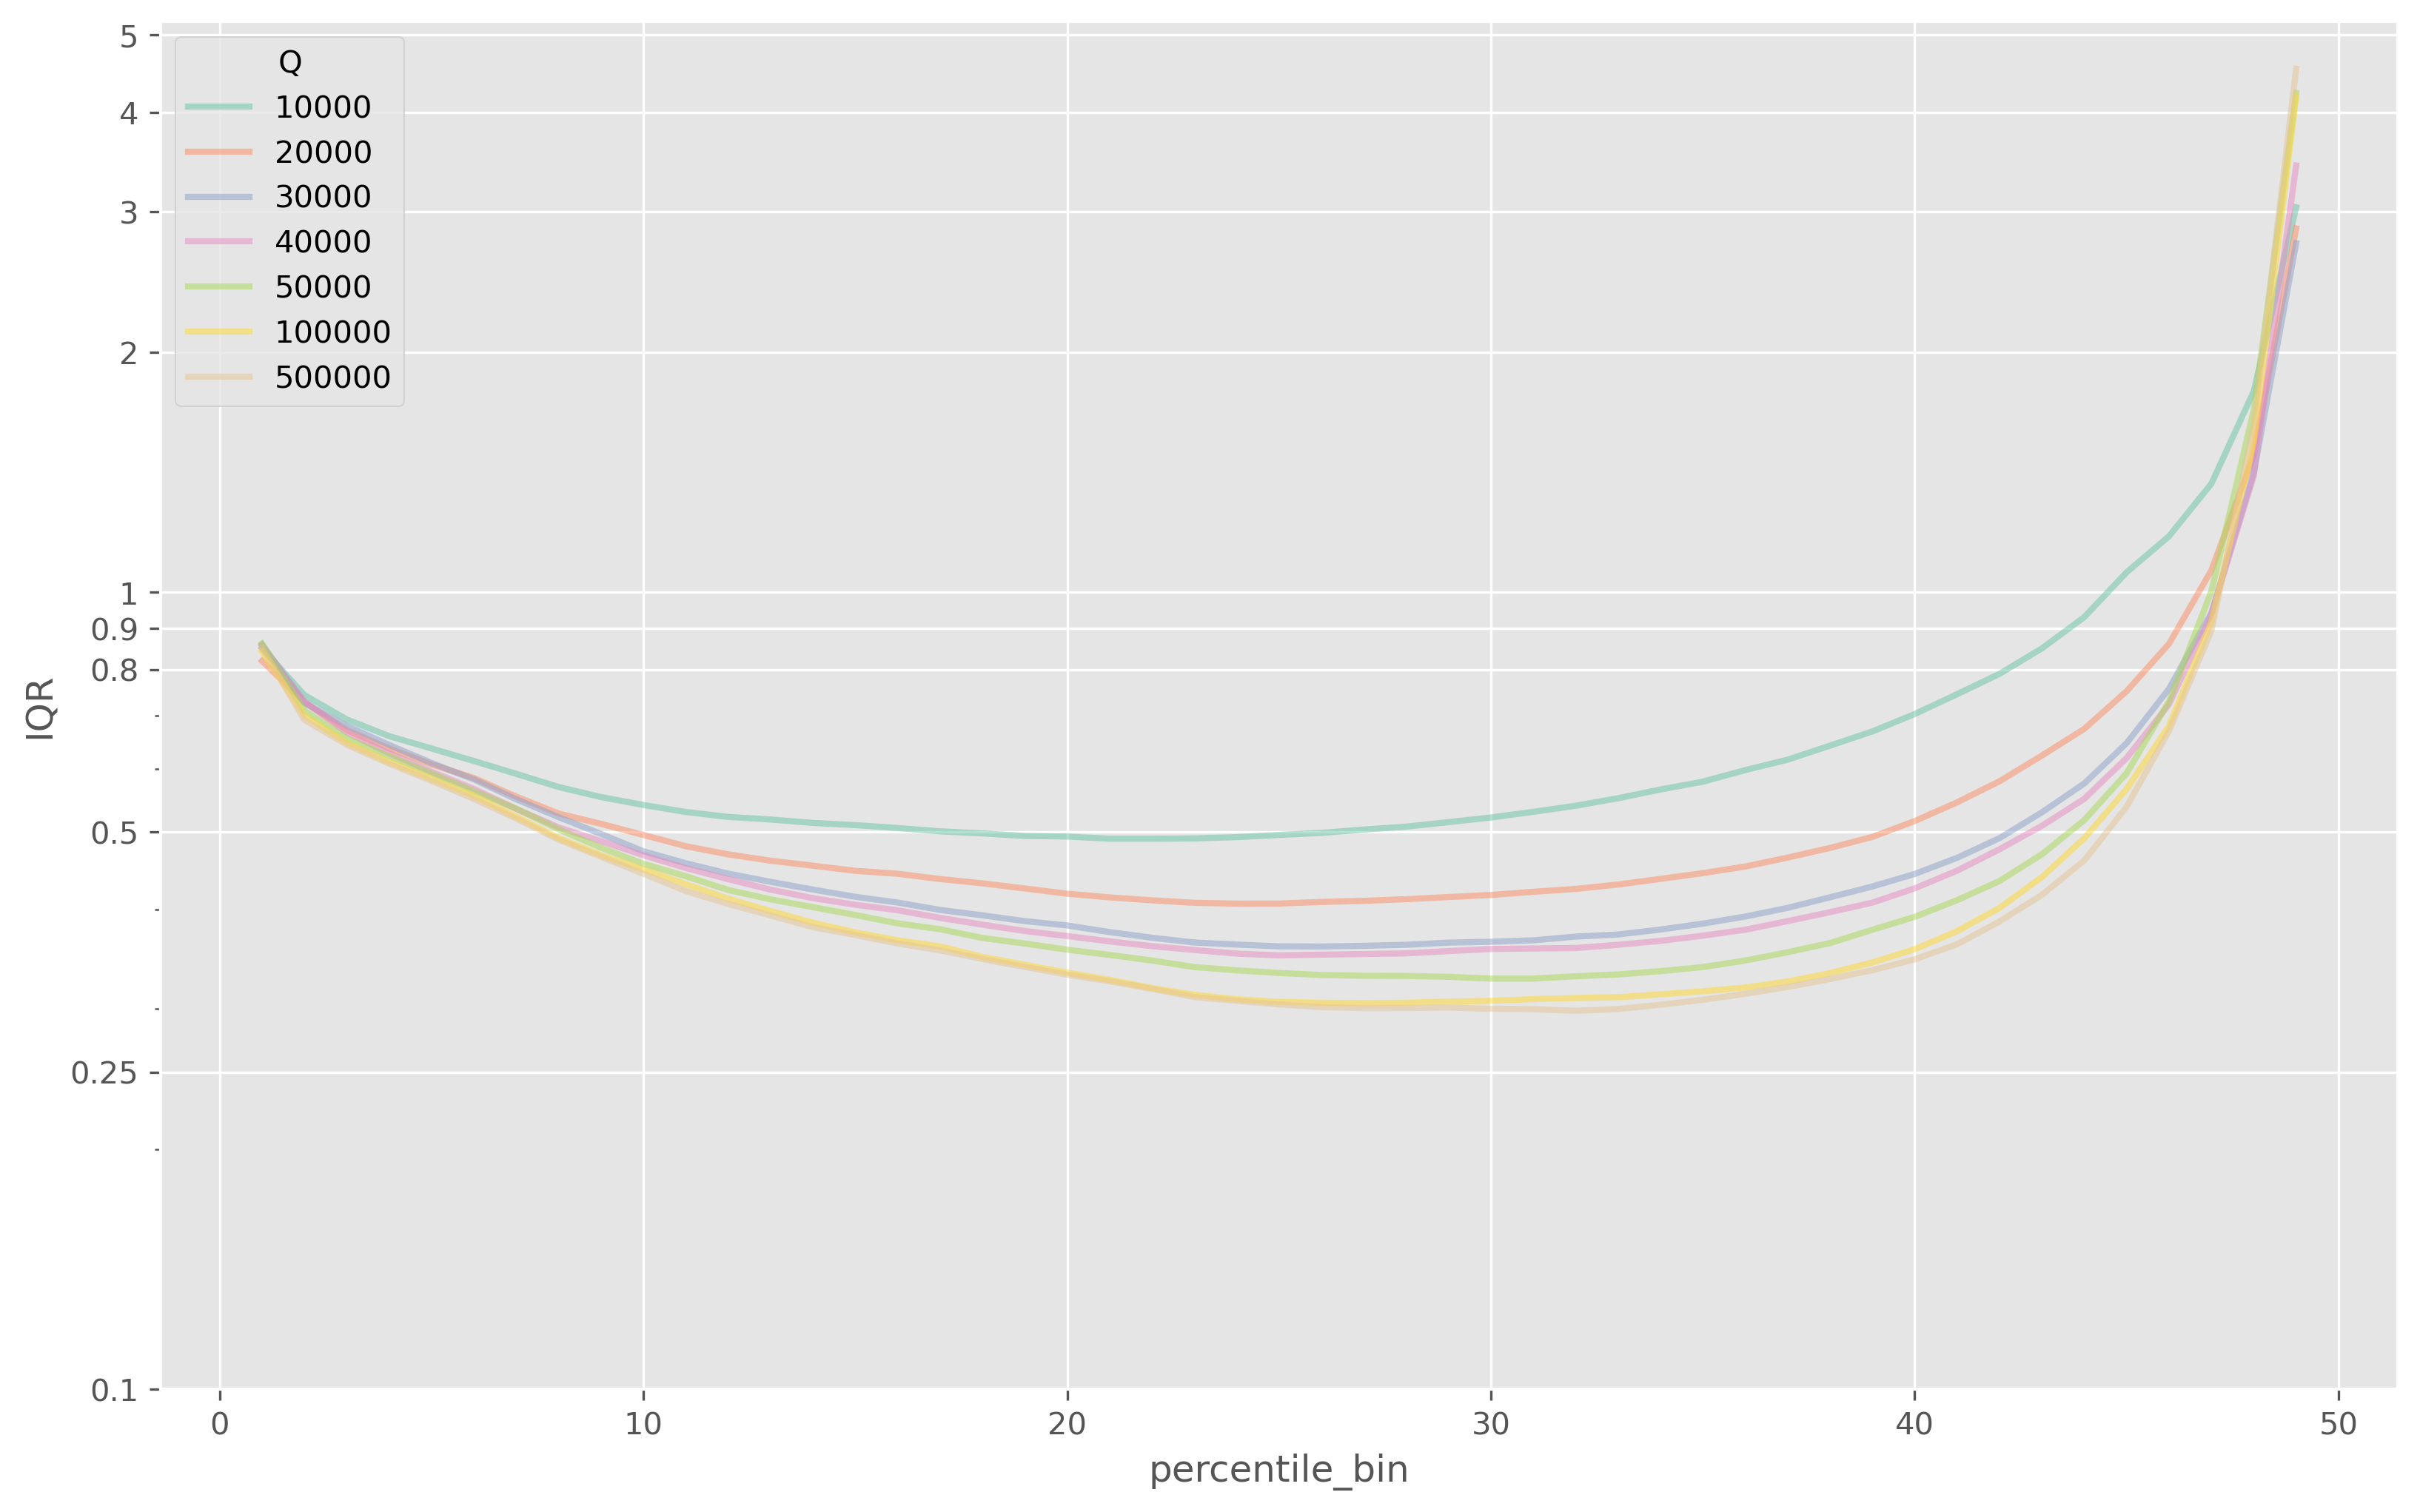

In [ ]:
# plot how the IQR and contains_one change with the percentile range
fig, ax = plt.subplots(dpi=300)
d = rng_scan.groupby(["Q", "percentile_bin"])[["contains_one", "IQR"]].mean().reset_index()

sns.lineplot(data=d, x="percentile_bin", y="IQR", hue="Q", ax=ax, palette="Set2", linewidth=2, alpha=0.5)
ax.set_yscale("log")
yticks = [0.1, 0.25, 0.5, 0.8, 0.9, 1, 2, 3, 4, 5]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
